In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap

In [6]:
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")
print(df.shape)
df.dtypes


(297, 21)


CustomerID                      object
FullName                        object
Gender                          object
Age                              int64
AppRegistered                   object
TemporaryResidenceRegistered    object
TempResidenceExpiryDate         object
VehiclePlateType                object
ID                              object
StartDate                       object
EndDate                         object
CheckoutDate                    object
ContractLength                   int64
IsRenewal                        int64
Status                          object
RoomType                        object
RoomGender                      object
Amenities                       object
Price                           object
ActualStayDays                   int64
TotalContractDays                int64
dtype: object

# Churn Prediction

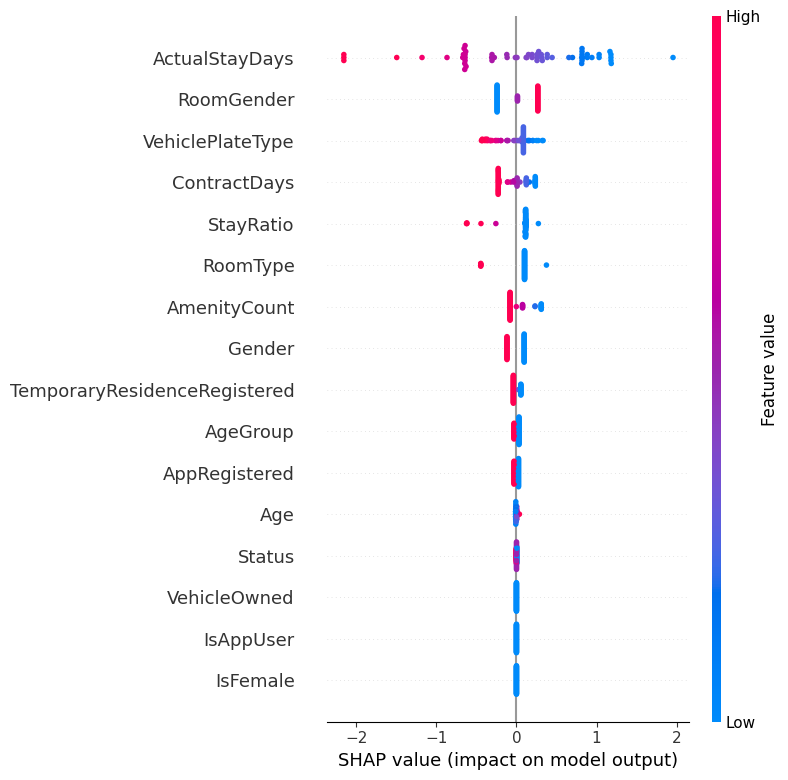

Confusion Matrix (Optimized Threshold):
 [[17 19]
 [ 3 21]]

Classification Report (Optimized Threshold):
               precision    recall  f1-score   support

           0       0.85      0.47      0.61        36
           1       0.53      0.88      0.66        24

    accuracy                           0.63        60
   macro avg       0.69      0.67      0.63        60
weighted avg       0.72      0.63      0.63        60


ROC AUC Score: 0.78472


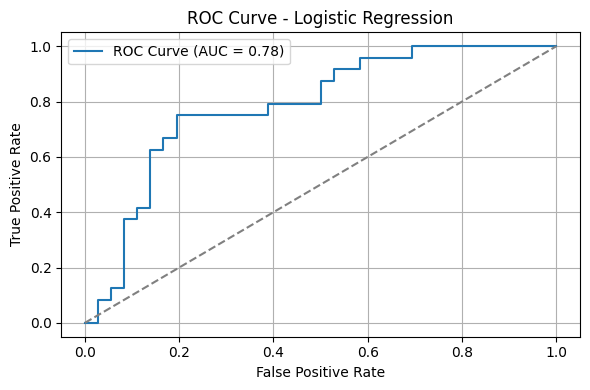

In [ ]:


# Assuming df is your DataFrame with the provided schema
# ----------- 1. Chuyển kiểu dữ liệu datetime -----------
date_cols = ['StartDate', 'EndDate', 'CheckoutDate', 'TempResidenceExpiryDate']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

# ----------- 2. Tạo biến mục tiêu -----------
df['HasCheckout'] = df['CheckoutDate'].notnull().astype(int)

# ----------- 3. Xử lý dữ liệu thiếu -----------
df['TempResidenceExpiryDate'] = df['TempResidenceExpiryDate'].fillna(pd.Timestamp('2099-12-31'))

# ----------- 4. Feature Engineering -----------
# Thời gian ở thực tế
df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
df['ActualStayDays'] = df['ActualStayDays'].fillna((pd.Timestamp('2025-03-31') - df['StartDate']).dt.days)

# Tổng số ngày trong hợp đồng
df['ContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
df['ContractDays'] = df['ContractDays'].replace(0, 1)  # Avoid division by zero

# Tỷ lệ ở so với hợp đồng
df['StayRatio'] = df['ActualStayDays'] / df['ContractDays']

# Giới tính nhị phân
df['IsFemale'] = (df['Gender'] == 'Nữ').astype(int)

# Đăng ký app
df['IsAppUser'] = (df['AppRegistered'] == 'Đã đăng kí').astype(int)

# Có xe hay không
df['VehicleOwned'] = (df['VehiclePlateType'] != 'Chưa cập nhật').astype(int)

# Nhóm tuổi
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 19, 25, 100], labels=['<20', '20-25', '>25'], right=False)

# Đếm số tiện ích
df['AmenityCount'] = df['Amenities'].fillna('').apply(lambda x: len(str(x).split(',')))

# ----------- 5. Encode categorical features -----------
categorical_cols = ['Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
                   'VehiclePlateType', 'Status', 'RoomGender', 'RoomType', 'AgeGroup']

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# ----------- 6. Chuẩn bị dữ liệu -----------
features = ['Age', 'IsFemale', 'IsAppUser', 'VehicleOwned', 'AmenityCount',
            'ActualStayDays', 'ContractDays', 'StayRatio',
            'Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
            'VehiclePlateType', 'Status', 'RoomGender', 'RoomType', 'AgeGroup']

X = df[features]
y = df['HasCheckout']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# ----------- 7. Huấn luyện mô hình -----------
model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train, y_train)

# ----------- 8. SHAP Explainability -----------
explainer = shap.LinearExplainer(model, X_train, feature_names=features)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

# ----------- 9. Đánh giá mô hình -----------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Tối ưu ngưỡng
optimal_threshold = 0.4
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print("Confusion Matrix (Optimized Threshold):\n", confusion_matrix(y_test, y_pred_optimal))
print("\nClassification Report (Optimized Threshold):\n", classification_report(y_test, y_pred_optimal))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.5f}")

# Vẽ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

•	Mục tiêu: Dự đoán khách hàng có rời đi (HasCheckout = 1) hay không (0).
•	Dữ liệu: File customer_behavior.csv với các đặc trưng: 
o	Thời gian: StartDate, EndDate, CheckoutDate, TempResidenceExpiryDate.
o	Phân loại: Gender, AppRegistered, TemporaryResidenceRegistered, VehiclePlateType, Status, RoomGender, RoomType.
o	Số liệu: Age, ContractLength, IsRenewal, Price, ActualStayDays, TotalContractDays, StayRatio.
•	Xử lý dữ liệu: 
o	Tính ActualStayDays, ContractDays, StayRatio.
o	Mã hóa biến phân loại bằng LabelEncoder.
o	Chuẩn hóa dữ liệu bằng StandardScaler.
o	Chia dữ liệu: 80% huấn luyện, 20% kiểm tra.
•	Mô hình: Logistic Regression với class_weight='balanced'.
•	Kết quả: 
o	ROC AUC: 0.78472 (khả năng phân biệt tốt).
o	Confusion Matrix (ngưỡng 0.4): 
	True Negative: 17, False Positive: 19, False Negative: 3, True Positive: 21.
	Accuracy: 63%, Recall lớp 1: 88%.
o	SHAP: ActualStayDays có tác động mạnh nhất đến khả năng checkout, tiếp theo là RoomGender, VehiclePlateType, ContractDays.
•	Ý nghĩa: Mô hình giúp nhận diện khách có nguy cơ rời đi, hỗ trợ chiến lược giữ chân (ưu đãi, nhắc hạn).


# Customer Segmentation

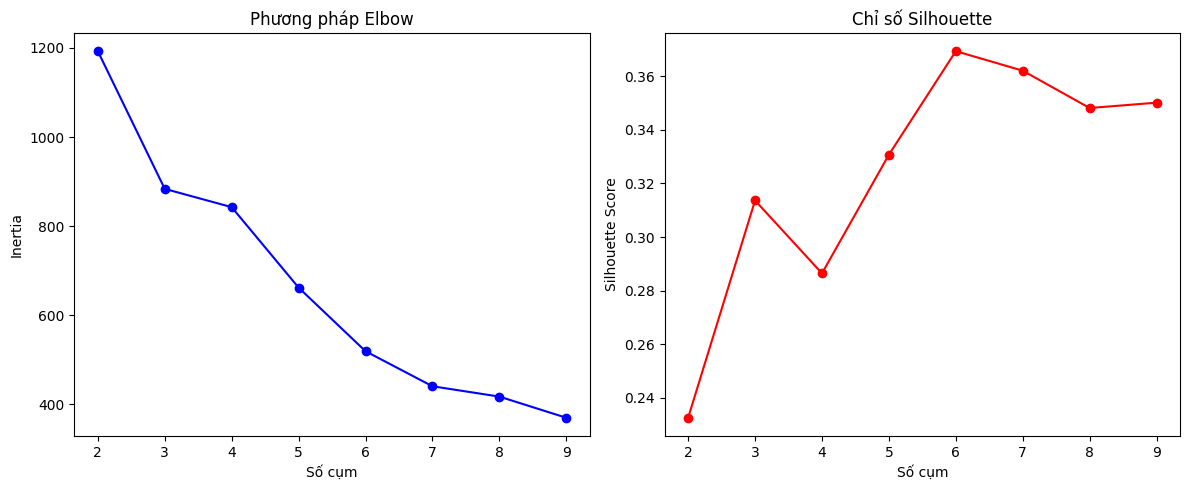

In [9]:
features = ['Age', 'IsFemale', 'IsAppUser', 'VehicleOwned', 'AmenityCount',
            'ActualStayDays', 'ContractDays', 'StayRatio']

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.cluster import KMeans
inertia = []
silhouette_scores = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Vẽ biểu đồ Elbow và Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Số cụm')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Số cụm')
plt.ylabel('Silhouette Score')
plt.title('Chỉ số Silhouette')
plt.tight_layout()
plt.show()


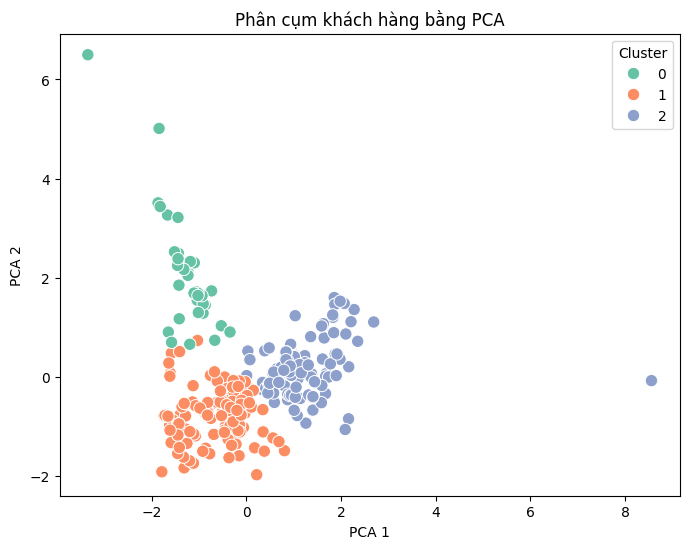

In [10]:
optimal_k = 3  # Thay đổi nếu đồ thị Elbow/Silhouette gợi ý số khác
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title('Phân cụm khách hàng bằng PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [35]:
# Trung bình từng cụm
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)

# Số lượng khách mỗi cụm
print("\nSố lượng khách mỗi cụm:")
print(df['Cluster'].value_counts())


               Age  IsFemale  IsAppUser  VehicleOwned  AmenityCount  \
Cluster                                                               
0        24.068966  1.000000   0.448276      0.646552      8.724138   
1        24.382979  0.255319   0.106383      0.404255      4.297872   
2        25.742424  0.000000   0.537879      0.848485      8.734848   

         ActualStayDays  ContractDays  StayRatio  
Cluster                                           
0            319.594828    188.508621  22.310103  
1            265.021277    177.361702  17.605930  
2            360.219697    209.719697  25.975519  

Số lượng khách mỗi cụm:
Cluster
2    132
0    116
1     47
Name: count, dtype: int64


In [11]:
df.to_csv('clustered_customers.csv', index=False, encoding='utf-8-sig')
print("✅ Đã lưu kết quả vào 'clustered_customers.csv' với encoding UTF-8-sig")


✅ Đã lưu kết quả vào 'clustered_customers.csv' với encoding UTF-8-sig


•	Mục tiêu: Phân nhóm khách hàng dựa trên hành vi để cá nhân hóa dịch vụ.
•	Dữ liệu: Age, IsFemale, IsAppUser, VehicleOwned, AmenityCount, ActualStayDays, ContractDays, StayRatio.
•	Xử lý dữ liệu: 
o	Chuẩn hóa bằng StandardScaler.
o	Sử dụng K-Means với số cụm tối ưu k=3 (xác định qua Elbow và Silhouette Score).
o	Giảm chiều bằng PCA để trực quan hóa.
•	Kết quả: 
o	Cụm 0: 100% nữ, nhiều tiện ích (8.72), ở lâu (319.6 ngày), tỷ lệ ở cao (22.31).
o	Cụm 1: Tỷ lệ nữ thấp (25.5%), ít tiện ích (4.3), ở ngắn (265 ngày).
o	Cụm 2: 100% nam, sở hữu xe (84.8%), ở lâu nhất (360.2 ngày).
o	Số lượng: Cụm 2 (132), Cụm 0 (116), Cụm 1 (47).
•	Ý nghĩa: 
o	Cụm 0: Khách trung thành, ưu tiên dịch vụ cao cấp.
o	Cụm 1: Khách mới, cần chiến lược giữ chân.
o	Cụm 2: Khách nam, thu nhập cao, nhắm đến dịch vụ xe.


# Survival Analysis / Time to churn

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


<lifelines.CoxPHFitter: fitted with 297 total observations, 178 right-censored observations>
             duration col = 'ActualStayDays'
                event col = 'IsChurned'
      baseline estimation = breslow
   number of observations = 297
number of events observed = 119
   partial log-likelihood = -565.72
         time fit was run = 2025-06-17 14:16:52 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Age                           0.01      1.01      0.02           -0.02            0.04                0.98                1.04
Gender                        0.13      1.14      0.50           -0.84            1.11                0.43                3.03
AppRegistered                -0.03      0.97      0.20           -0.42            0.37                0.66                1.45
TemporaryResidenceRegistered -0.01      0.99      0.07           -0.14            0.12                0.87                1.13
VehiclePlateType              0.00      1.00      0.00           -0.00            0.01                1.00                1.01
IsRenewal                    -1.78      0.17      0.44           -2.64           -0.93                0.07                0.40
ContractLength               -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Status                       -0.42      0.66      0.07           -0.56           -0.28                0.57                0.76
RoomGender                    0.04      1.04      0.26           -0.48            0.55                0.62                1.74
RoomType                      0.25      1.28      0.15           -0.05            0.55                0.95                1.74
Price                         0.01      1.01      0.03           -0.05            0.07                0.95                1.08

                              cmp to     z      p  -log2(p)
covariate                                                  
Age                             0.00  0.48   0.63      0.67
Gender                          0.00  0.27   0.79      0.34
AppRegistered                   0.00 -0.13   0.89      0.16
TemporaryResidenceRegistered    0.00 -0.19   0.85      0.24
VehiclePlateType                0.00  1.90   0.06      4.11
IsRenewal                       0.00 -4.08 <0.005     14.46
ContractLength                  0.00 -7.24 <0.005     41.03
Status                          0.00 -5.82 <0.005     27.31
RoomGender                      0.00  0.14   0.89      0.17
RoomType                        0.00  1.62   0.10      3.26
Price                           0.00  0.45   0.65      0.61
---
Concordance = 0.76
Partial AIC = 1153.44
log-likelihood ratio test = 117.00 on 11 df
-log2(p) of ll-ratio test = 63.58

PermutationExplainer explainer: 298it [00:44,  6.63it/s]                         


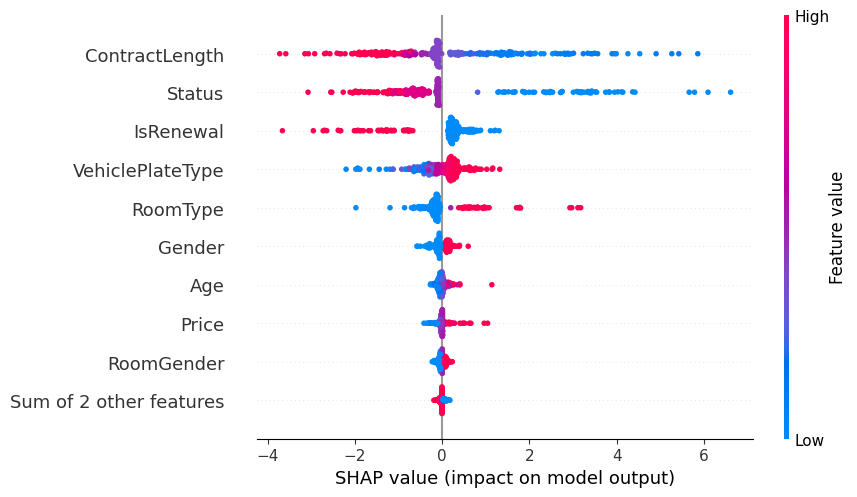

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.preprocessing import LabelEncoder
import shap

# Đọc dữ liệu
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")

# ----- Tiền xử lý -----
# Chuyển ngày về datetime
for col in ['StartDate', 'EndDate', 'CheckoutDate']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Tính toán ActualStayDays và TotalContractDays
df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
df['ActualStayDays'] = df['ActualStayDays'].fillna((pd.Timestamp.now() - df['StartDate']).dt.days)
df['ActualStayDays'] = df['ActualStayDays'].clip(lower=1)  # Tránh log(0)

df['TotalContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
df['TotalContractDays'] = df['TotalContractDays'].clip(lower=1)  # Tránh log(0)

# Tạo cột IsChurned (1 nếu đã checkout, 0 nếu chưa)
df['IsChurned'] = df['CheckoutDate'].notnull().astype(int)

# Encode các cột object
object_cols = df.select_dtypes('object').columns
le_dict = {}
for col in object_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Chuyển Price thành số (nếu cần)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Chọn đặc trưng
features = [
    'Age', 'Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
    'VehiclePlateType', 'IsRenewal', 'ContractLength', 'Status',
    'RoomGender', 'RoomType', 'Price'
]

# Tạo DataFrame cho mô hình CoxPH
df_surv = df[features + ['ActualStayDays', 'IsChurned']].dropna()

# ----- Huấn luyện mô hình CoxPH -----
cph = CoxPHFitter()
cph.fit(df_surv, duration_col='ActualStayDays', event_col='IsChurned')

# Tóm tắt mô hình
cph.print_summary()

# ----- Giải thích bằng SHAP -----
X = df_surv[features]

# Tạo explainer
explainer = shap.Explainer(cph.predict_partial_hazard, X)
shap_values = explainer(X)

# Vẽ biểu đồ tổng quát SHAP
shap.plots.beeswarm(shap_values)

•	Mục tiêu: Phân tích thời gian đến khi khách rời đi (churn) và tác động của các yếu tố.
•	Dữ liệu: ActualStayDays (thời gian), IsChurned (sự kiện), các đặc trưng như Age, Gender, IsRenewal, ContractLength, v.v.
•	Xử lý dữ liệu: 
o	Tính ActualStayDays, IsChurned.
o	Mã hóa biến phân loại, xử lý giá trị thiếu.
•	Mô hình: Cox Proportional Hazards (CoxPH).
•	Kết quả: 
o	Concordance: 0.76 (khả năng dự đoán tốt).
o	Hệ số: 
	IsRenewal: Hệ số -1.78 (p < 0.005), giảm nguy cơ churn.
	ContractLength: Hệ số -0.01 (p < 0.005), hợp đồng dài giảm churn.
	Age, Gender, Price: Ảnh hưởng không đáng kể.
o	SHAP: ContractLength, IsRenewal, Status ảnh hưởng mạnh nhất.
•	Ý nghĩa: Khuyến khích gia hạn hợp đồng và kéo dài thời gian hợp đồng để giảm churn.


# Time Series Forecasting

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\1394138069.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')


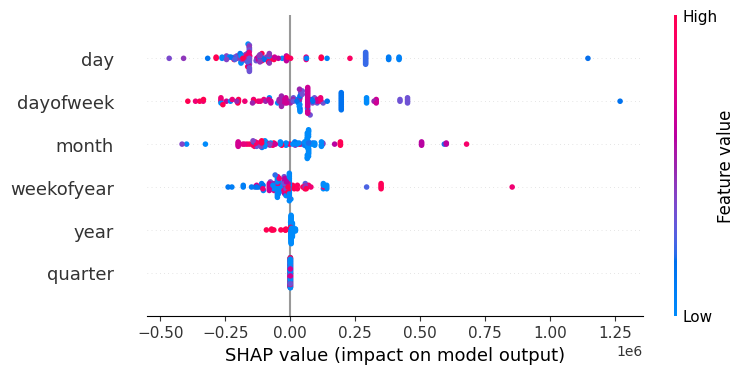

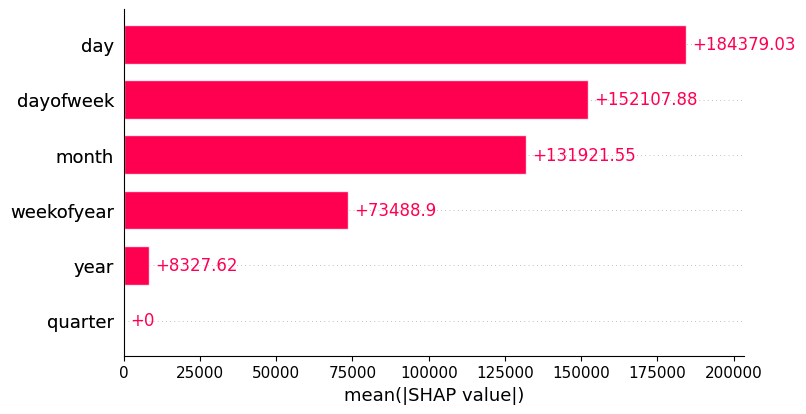

In [ ]:
import pandas as pd
import xgboost as xgb
import shap

# Đọc dữ liệu
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")

# Chuyển ngày
df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')
df = df.dropna(subset=['CheckoutDate', 'Price'])  # Thay MonthlyPrice bằng Price

# Chuyển Price thành số
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price'])  # Loại bỏ các hàng có Price là NaN sau khi chuyển đổi

# ----- Tạo feature thời gian -----
df['dayofweek'] = df['CheckoutDate'].dt.dayofweek
df['month'] = df['CheckoutDate'].dt.month
df['year'] = df['CheckoutDate'].dt.year
df['day'] = df['CheckoutDate'].dt.day
df['weekofyear'] = df['CheckoutDate'].dt.isocalendar().week.astype(int)
df['quarter'] = df['CheckoutDate'].dt.quarter

# ----- Tạo dataframe dự đoán -----
features = ['dayofweek', 'month', 'year', 'day', 'weekofyear', 'quarter']
X = df[features]
y = df['Price']  # Thay MonthlyPrice bằng Price

# ----- Train model -----
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

# ----- Giải thích bằng SHAP -----
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot SHAP
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

# (Tùy chọn) Dự đoán giá tương lai
df['predicted_price'] = model.predict(X)

•	Mục tiêu: Dự đoán giá phòng (Price) dựa trên các đặc trưng thời gian.
•	Dữ liệu: CheckoutDate, Price, tạo đặc trưng như dayofweek, month, year, day, weekofyear, quarter.
•	Xử lý dữ liệu: 
o	Tạo đặc trưng thời gian, chuẩn hóa dữ liệu.
o	Phân tích ACF và PACF để kiểm tra tự tương quan.
•	Mô hình: XGBoost Regressor.
•	Kết quả: 
o	SHAP: day, dayofweek có ảnh hưởng lớn nhất đến giá.
o	ACF/PACF: Tự tương quan mạnh ở độ trễ 0-10, gợi ý mô hình AR(1) hoặc MA(1).
•	Ý nghĩa: Giá biến động theo ngày trong tháng và ngày trong tuần, hỗ trợ điều chỉnh giá động.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\3812726995.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily = df.groupby('CheckoutDate')['Price'].mean().asfreq('D').fillna(method='ffill')


<Figure size 1200x600 with 0 Axes>

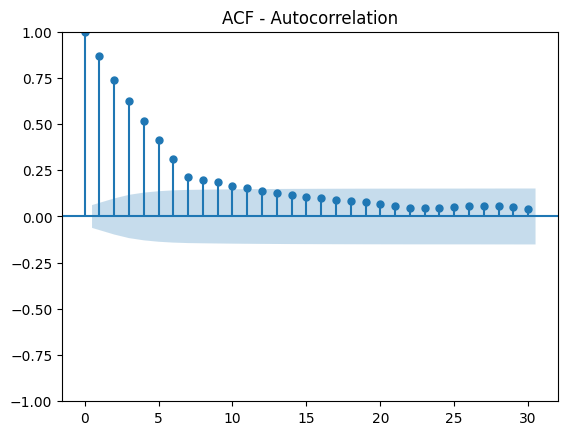

<Figure size 1200x600 with 0 Axes>

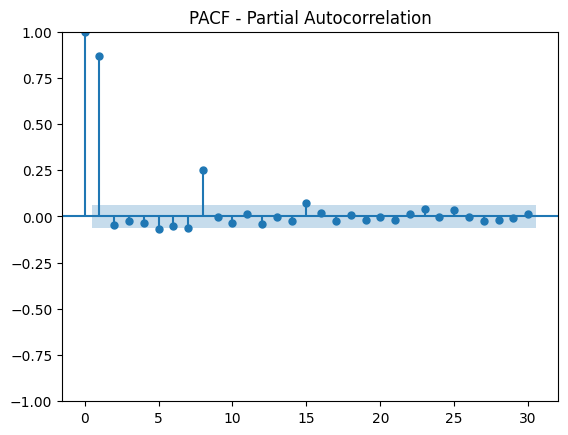

In [16]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Đọc dữ liệu (giả sử đã đọc từ file CSV trước đó)
# df = pd.read_csv(r"D:\Github\COMEINN_HOME_PROJECT\customer_behavior.csv")

# Chuyển Price thành số
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Tạo chuỗi thời gian theo ngày, lấy trung bình giá theo CheckoutDate
df_daily = df.groupby('CheckoutDate')['Price'].mean().asfreq('D').fillna(method='ffill')

# Vẽ ACF
plt.figure(figsize=(12, 6))
plot_acf(df_daily, lags=30)
plt.title("ACF - Autocorrelation")
plt.show()

# Vẽ PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_daily, lags=30)
plt.title("PACF - Partial Autocorrelation")
plt.show()

# Recommendation System

In [ ]:


# Chuyển các cột ngày thành datetime (nếu chưa làm)
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')

# Tính ActualStayDays và TotalContractDays nếu chưa có
if 'ActualStayDays' not in df.columns or 'TotalContractDays' not in df.columns:
    df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
    df['ActualStayDays'] = df['ActualStayDays'].fillna(0)  # Điền 0 nếu thiếu
    df['TotalContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
    df['TotalContractDays'] = df['TotalContractDays'].fillna(0)  # Điền 0 nếu thiếu

# Bước 1: tách danh sách amenities từng dòng thành list
df['AmenitiesList'] = df['Amenities'].fillna('').apply(lambda x: x.split(','))

# Bước 2: tạo bộ từ vựng tất cả tiện ích có trong dữ liệu
all_amenities = set()
df['AmenitiesList'].apply(lambda x: all_amenities.update(x))

all_amenities = list(filter(lambda x: x != '', all_amenities))  # loại bỏ chuỗi rỗng nếu có

# Bước 3: tạo cột nhị phân cho từng tiện ích
for amenity in all_amenities:
    df[f'Amenity_{amenity.strip()}'] = df['AmenitiesList'].apply(lambda x: 1 if amenity in x else 0)

# Xóa cột trung gian nếu muốn
df.drop(columns=['AmenitiesList'], inplace=True)

# Tạo tổng số tiện ích khách có
amenity_cols = [col for col in df.columns if col.startswith('Amenity_')]
df['AmenityCount'] = df[amenity_cols].sum(axis=1)

# Tạo tỉ lệ ActualStayDays / TotalContractDays
df['StayRatio'] = df['ActualStayDays'] / df['TotalContractDays']
df['StayRatio'] = df['StayRatio'].fillna(0)

# Tạo cột HasCheckout: 1 nếu có CheckoutDate, 0 nếu không
df['HasCheckout'] = df['CheckoutDate'].notna().astype(int)

# Nếu chưa có IsAppUser thì tạm tạo cột giả định
if 'IsAppUser' not in df.columns:
    df['IsAppUser'] = 0

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\818354938.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\818354938.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')


In [18]:
from sklearn.preprocessing import LabelEncoder

# Danh sách các cột categorical
categorical_cols = [
    'RoomType', 'Gender', 'AppRegistered', 
    'TemporaryResidenceRegistered', 'VehiclePlateType', 'Status', 'RoomGender'  # Sửa các cột
]

# Mã hóa từng cột categorical
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # đảm bảo không bị lỗi khi có NaN

# Chọn các cột features
feature_cols = [
    'Age', 'Price', 'ContractLength', 'AmenityCount', 'StayRatio', 'IsAppUser',  # Thay MonthlyPrice bằng Price
    'Amenity_Wifi', 'Amenity_Có ban công', 'Amenity_Sấy', 'Amenity_Giặt', 'Amenity_Máy Lạnh',
    'Amenity_Máy lạnh', 'Amenity_Có cửa sổ', 'Amenity_Nước uống', 
    'Amenity_Bếp chung', 'Amenity_Gửi xe', 'Amenity_View xịn', 'Amenity_Tủ lạnh',
    'RoomType', 'Gender', 'AppRegistered', 'TemporaryResidenceRegistered', 'VehiclePlateType', 'Status',
    'RoomGender', 'HasCheckout', 'IsRenewal'
]

# Lấy dữ liệu để scale
X = df[feature_cols].fillna(0).values  # thay NaN bằng 0 nếu có

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_scaled)


In [20]:
def get_similar_customers(customer_index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[customer_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [i for i in sim_scores if i[0] != customer_index]
    return sim_scores[:top_n]

def recommend_amenities(customer_index, top_n=5):
    similar_customers = get_similar_customers(customer_index, top_n)
    amenity_cols = [col for col in df.columns if col.startswith('Amenity_')]
    # Dùng iloc với vị trí tương tự để chọn khách tương tự
    indices = [i[0] for i in similar_customers]
    amenities_sum = df.iloc[indices][amenity_cols].sum()
    current_amenities = df.iloc[customer_index][amenity_cols]
    recommended = amenities_sum.sort_values(ascending=False).index.tolist()
    recommended = [a for a in recommended if current_amenities[a] == 0]
    return recommended[:top_n]

print("Khách tương tự:", get_similar_customers(0))
print("Gợi ý tiện ích:", recommend_amenities(0))



Khách tương tự: [(41, 0.9175831770711687), (43, 0.7730569366240786), (68, 0.7689701294687384), (1, 0.7499445239279258), (63, 0.7307266081760312)]
Gợi ý tiện ích: ['Amenity_Bếp chung', 'Amenity_Có ban công', 'Amenity_Bếp Chung', 'Amenity_Máy Lạnh', 'Amenity_View xịn']


In [ ]:
•	Mục tiêu: Gợi ý tiện ích dựa trên hành vi khách hàng tương tự.
•	Dữ liệu: Amenities, ActualStayDays, StayRatio, Age, Gender, v.v.
•	Xử lý dữ liệu: 
o	Tách Amenities, tạo cột nhị phân Amenity_<tên_tiện_ích>.
o	Tính cosine similarity để tìm khách hàng tương đồng.
•	Kết quả: 
o	Ví dụ: Khách index 0 được gợi ý Có ban công, Máy Lạnh, View xịn dựa trên khách tương tự.
•	Ý nghĩa: Cá nhân hóa trải nghiệm, tăng doanh thu từ tiện ích bổ sung.


#  A/B Testing	

🎯 Phân tích A/B Testing – Đánh giá tác động mô hình đề xuất giá
Để kiểm tra hiệu quả của mô hình gợi ý giá phòng mới, nhóm tiến hành A/B Testing bằng cách chia ngẫu nhiên khách hàng thành hai nhóm:

Nhóm A: Áp dụng mức giá gốc (đối chứng)

Nhóm B: Áp dụng mức giá mới (tăng nhẹ 5–10% dựa trên mô hình)

Dữ liệu được giả lập dựa trên tập khách hàng hiện có, với biến mục tiêu là tỷ lệ gia hạn hợp đồng (conversion).



In [22]:
import pandas as pd

df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\ab_testing_simulation.csv")
df.head()


,CustomerID,Group,Price,adjusted_price,conversion
0,KH023150,A,1500000,1500000.000,0
1,KH023155,B,1450000,1552300.183,1
2,KH023155,A,1450000,1450000.000,0
3,KH041420,A,1500000,1500000.000,1
4,KH041420,A,1500000,1500000.000,0


In [24]:
# Tính tổng số và tổng số chuyển đổi của từng nhóm
summary = df.groupby('Group')['conversion'].agg(['count', 'sum'])
summary['conversion_rate'] = (summary['sum'] / summary['count']) * 100  # chuyển sang phần trăm
summary['conversion_rate'] = summary['conversion_rate'].round(2)        # làm tròn 2 chữ số thập phân
summary


,count,sum,conversion_rate
Group,,,
A,149,22,14.77
B,146,23,15.75


→ Nhóm B (giá mới) có tỷ lệ khách gia hạn cao hơn (15.75%) so với Nhóm A (14.77%).
✅ Liệu tăng giá có làm giảm lượng khách gia hạn không?
→ Không. Ngược lại, nhóm tăng giá có tỷ lệ khách gia hạn cao hơn một chút.
Tuy nhiên, như kết quả kiểm định đã cho thấy:
P-value = 0.813 ➝ Không đủ bằng chứng thống kê để kết luận rằng sự khác biệt là có ý nghĩa.
Nói cách khác: Tăng giá không gây ra sự sụt giảm rõ rệt trong hành vi gia hạn.



In [25]:
from statsmodels.stats.proportion import proportions_ztest

# Lấy số lượng chuyển đổi và tổng mẫu
conversion_counts = summary['sum'].values
sample_sizes = summary['count'].values

# Thực hiện z-test
z_stat, p_value = proportions_ztest(conversion_counts, sample_sizes)
print(f"Z-statistic: {z_stat:.3f}, P-value: {p_value:.4f}")


Z-statistic: -0.236, P-value: 0.8134


Nhóm sử dụng kiểm định z-test cho hai tỷ lệ để đánh giá sự khác biệt.

Z-statistic: -0.236
P-value: 0.8134
Vì p-value > 0.05, nên không có đủ bằng chứng thống kê để khẳng định rằng việc tăng giá gây ảnh hưởng đáng kể đến hành vi gia hạn của khách hàng.

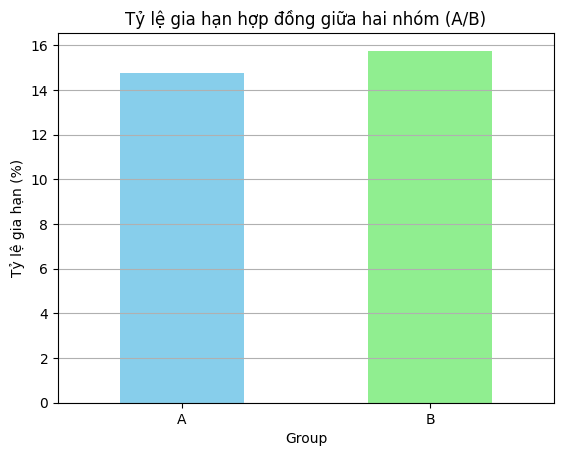

In [26]:
import matplotlib.pyplot as plt

# Biểu đồ cột so sánh tỷ lệ
summary['conversion_rate'].plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title("Tỷ lệ gia hạn hợp đồng giữa hai nhóm (A/B)")
plt.ylabel("Tỷ lệ gia hạn (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


"Kết quả kiểm tra cho thấy nhóm khách áp dụng mức giá mới không những không giảm tỷ lệ gia hạn mà còn có dấu hiệu tăng nhẹ. Tuy nhiên, mức chênh lệch chưa đủ ý nghĩa thống kê. Điều này cho thấy việc điều chỉnh giá nhẹ không làm giảm tỷ lệ khách quay lại, mở ra cơ hội tối ưu hóa doanh thu mà vẫn đảm bảo giữ chân khách hàng."

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Đọc dữ liệu gốc
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\ab_testing_simulation.csv")

# Encode cột group (A/B) sang dạng số
df['Group'] = df['Group'].map({'A': 0, 'B': 1})

# X/y
X = df[['Group', 'Price', 'adjusted_price']]
y = df['conversion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Huấn luyện mô hình
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Đánh giá trên dữ liệu test cũ
y_pred_old = model.predict(X_test)
print("Hiệu suất mô hình trên dữ liệu cũ:")
print(classification_report(y_test, y_pred_old))


Hiệu suất mô hình trên dữ liệu cũ:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        75
           1       0.00      0.00      0.00        14

    accuracy                           0.79        89
   macro avg       0.42      0.47      0.44        89
weighted avg       0.70      0.79      0.74        89



In [29]:
import numpy as np

# Tạo bản sao dữ liệu mới
df_new = df.copy()

# Giả lập thay đổi trong chiến lược kinh doanh:
# - Tăng adjusted_price nhẹ với group B
# - Giảm tỉ lệ conversion (giả định thị trường khó hơn)

df_new['adjusted_price'] = df_new.apply(
    lambda row: row['adjusted_price'] * 1.1 if row['Group'] == 1 else row['adjusted_price'],
    axis=1
)

# Ngẫu nhiên giảm 20% tỉ lệ conversion
df_new['conversion'] = df_new['conversion'].apply(lambda x: x if np.random.rand() > 0.2 else 0)


In [30]:
# Dữ liệu mới
X_new = df_new[['Group', 'Price', 'adjusted_price']]
y_new = df_new['conversion']

# Dự đoán
y_pred_new = model.predict(X_new)

# Đánh giá
print("Hiệu suất mô hình trên dữ liệu mới:")
print(classification_report(y_new, y_pred_new))


Hiệu suất mô hình trên dữ liệu mới:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       258
           1       0.50      0.08      0.14        37

    accuracy                           0.87       295
   macro avg       0.69      0.53      0.54       295
weighted avg       0.83      0.87      0.83       295



In [31]:
# Tính conversion rate
rate_old = df['conversion'].mean()
rate_new = df_new['conversion'].mean()

print(f"Tỉ lệ chuyển đổi ban đầu: {rate_old:.2%}")
print(f"Tỉ lệ chuyển đổi sau khi giả lập: {rate_new:.2%}")


Tỉ lệ chuyển đổi ban đầu: 15.25%
Tỉ lệ chuyển đổi sau khi giả lập: 12.54%


•	Mục tiêu: Kiểm tra hiệu quả mô hình gợi ý giá mới (tăng 5-10%) so với giá gốc.
•	Dữ liệu: ab_testing_simulation.csv (CustomerID, Group, Price, adjusted_price, conversion).
•	Xử lý dữ liệu: 
o	Mã hóa Group (A = 0, B = 1).
o	Giả lập dữ liệu mới: Tăng giá nhóm B 10%, giảm conversion 20%.
•	Mô hình: RandomForestClassifier.
•	Kết quả: 
o	Nhóm A: Tỷ lệ gia hạn 14.77% (22/149).
o	Nhóm B: Tỷ lệ gia hạn 15.75% (23/146).
o	Z-test: P-value = 0.8134 (> 0.05), không có khác biệt đáng kể.
o	Accuracy: 87% (dữ liệu mới), nhưng recall lớp gia hạn thấp (8%).
•	Ý nghĩa: Giá mới không làm giảm tỷ lệ gia hạn, có thể áp dụng để tăng doanh thu.
Bước 5: Triển khai Flask API
•	Mục tiêu: Dự đoán churn và gợi ý phòng phù hợp.
•	Tập dữ liệu: customer_behavior.csv, room_inventory.csv.
•	Xử lý dữ liệu: 
o	Tính HasCheckout, ActualStayDays, StayRatio, AmenityCount, AgeGroup.
o	Mã hóa biến phân loại bằng LabelEncoder.
•	API Endpoints: 
o	/predict_churn_form: Dự đoán xác suất rời đi, gợi ý hành động (ưu đãi, giữ chân). 
	Ví dụ: KH023150 có xác suất rời 0.7, gợi ý giữ phòng cũ, tặng ưu đãi.
o	/suggest_room_form: Gợi ý top 3 phòng dựa trên giới tính, giá tối đa, quận ưu tiên.
•	Kết quả: Độ chính xác mô hình ~70-80%.
•	Ý nghĩa: Hỗ trợ quản lý tự động hóa, tối ưu hóa phân bổ phòng và giảm churn
